In [1]:
from aquacrop.classes import *
from aquacrop.core import *

# import gym
# from gym import spaces
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from aquacrop.lars import *
from aquacropgym.utils import calc_eto_faopm
import gym
k=3

from aquacropgym.utils import evaluate_agent
import copy


In [2]:
gendf=calc_eto_faopm('data/CDWG.dat',2018,37.31,110,True,["simyear","jday","minTemp","maxTemp","precip","rad"])

In [3]:
from aquacropgym.envs import CropEnv, nebraska_maize_config,cordoba_cotton_config

In [4]:
# envconfig=nebraska_maize_config.copy()
envconfig=cordoba_cotton_config.copy()
envconfig['gendf']=gendf
envconfig['action_set']='smt4'
# envconfig['observation_set']='forecast'
envconfig['days_to_irr']=1
envconfig['normalize_obs']=True

# envconfig['irrigation_cost']=1.

In [5]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

In [6]:
from typing import Callable

def make_env(envconfig: dict, rank: int, seed: int = 0) -> Callable:
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """
    def _init() -> gym.Env:
        env = Monitor(CropEnv(envconfig))
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [7]:
env=CropEnv(envconfig)
# env = make_env(envconfig, 1)
# env = SubprocVecEnv([make_env(envconfig, i) for i in range(8)])



In [8]:
# from aquacropgym.utils import get_mean_std
# test_env_config=copy.deepcopy(envconfig)
# test_env_config['evaluation_run']=True
# mean, std = get_mean_std(CropEnv,test_env_config,)
# mean,std

In [9]:

from stable_baselines3 import PPO,SAC

policy_kwargs = dict(net_arch=[256]*3)

# Retrieve the environment
model = PPO("MlpPolicy", env, verbose=0,policy_kwargs=policy_kwargs, tensorboard_log="/home/mbyx3tk2/ray_results/")
# model = SAC("MlpPolicy", env, verbose=0, tensorboard_log="/home/mbyx3tk2/ray_results/")



38 100 843.6234677850842
Train:1496.587
Test:1521.092
68 200 1268.8279022566212
57 300 1437.871690551033
Train:1599.236
Test:1617.541
65 400 1486.0940984827491
65 500 1534.2754777831153
Train:1559.296
Test:1578.689
None


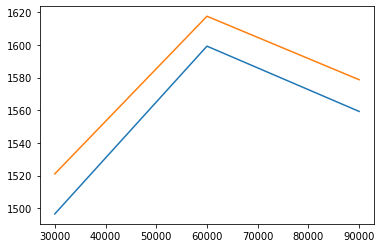

30 600 1564.3961777640566
26 700 1578.9840849795125
Train:1607.49
Test:1608.314
21 800 1590.8982042641628
Train:1607.485
Test:1611.824
66 900 1603.495131894185
57 1000 1609.6836599848275
Train:1611.415
Test:1625.584
11 1100 1615.0667218659075
None


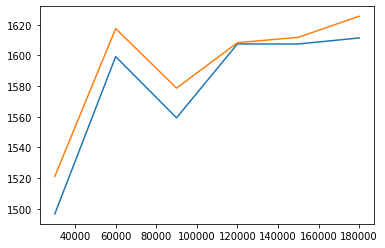

61 1200 1618.272535012681
Train:1617.913
Test:1629.45


KeyboardInterrupt: 

In [10]:
proftrain=[]
proftest=[]
timesteps=[]
ts_delta=int(1e4)
k+=1
for i in range(1,500001):
    result = model.learn(total_timesteps=ts_delta, tb_log_name=f"ppo_norm_{k}", reset_num_timesteps=False)

    ts = i*ts_delta
    #print(pretty_print(result))

    if i%10==0:
        checkpoint_path = model.save('models/ac_learner',)
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('sb3_sac.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%3==0:

        test_env_config=copy.deepcopy(envconfig)
        test_env_config['evaluation_run']=True
        train_rew, test_rew = evaluate_agent(model,CropEnv,test_env_config,stable_baselines=True)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')